<img src="../images/GA-logo.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Evidence-Based Political Analysis in the Age of Social Media


**Primary Objectives:**

1. Scrape tweets from two Twitter accounts
2. Use NLP to train a classifier to predict the account a given tweet comes from (i.e. binary classification)


In [21]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from model_evaluation import avg_f1_score, compute_score_specific, get_wrongs, fill_na_with_blank, lemmatize_column, process_coef
from data_cleaning import generate_wordcloud

import dill

%matplotlib inline

----

## Model & Data Import

In [2]:
model_NB = dill.load(open('../models/model_NB.sav', 'rb'))
model_NB_simplified = dill.load(open('../models/model_NB_simplified.sav', 'rb'))
model_RF = dill.load(open('../models/model_RF.sav', 'rb'))
model_RF_simplified = dill.load(open('../models/model_RF_simplified.sav', 'rb'))
model_LR = dill.load(open('../models/model_LR.sav', 'rb'))
model_LR_simplified = dill.load(open('../models/model_LR_simplified.sav', 'rb'))

In [3]:
X_train = pd.read_csv('../datasets/X_train.csv')
y_train = pd.read_csv('../datasets/y_train.csv').squeeze()
X_test = pd.read_csv('../datasets/X_test.csv')
y_test = pd.read_csv('../datasets/y_test.csv').squeeze()

----

## Model Evaluation

We run the models through the test dataset as a barometer to evaluate their performance. The summary of performance of various models is summarised below.

| Model | Training Avg F1 Score | 5-Fold Cross Val Avg F1 Score | Test Avg F1 Score |
| :- | -: | -: | -: |
| Baseline | 0.337 | - |  |
| **Messaging Only** |  |  |  |
| Naive Bayes Simplified | 0.950 | 0.925 | 0.919 |
| Random Forest Simplified | 0.967 | 0.918 | 0.914 |
| Logistic Regression Simplified | 0.968 | 0.925 | 0.921 |
| **All Aspects** |  |  |  |
| Naive Bayes | 0.924 | 0.902 | 0.917 |
| Random Forest | 0.937 | 0.918 | 0.925 |
| Logistic Regression | 0.974 | 0.939 | 0.941 |

After analysing the wrong predictions, we note that most of these predictions are difficult even for humans to differentiate. This is because of 
1. Lack of information due to the general nature of the tweet
2. Additional information embedded within the photos/videos/weblinks which the current models cannot extract

As such, we choose the full **Logistic Regression model** for further business insights.

### Compute test scores (full models)

Average F1 Score: 	0.917


0.917172431148184

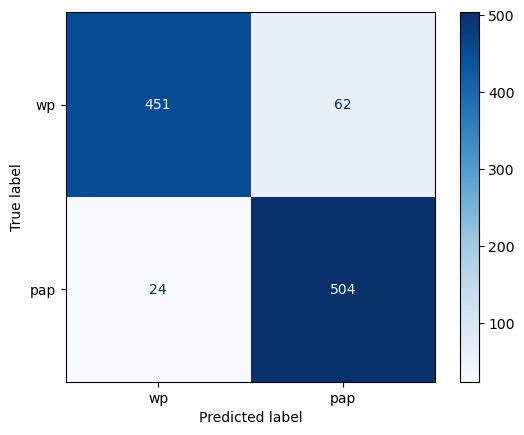

In [4]:
compute_score_specific(model_NB, X_test, y_test)

Average F1 Score: 	0.925


0.9247603762815143

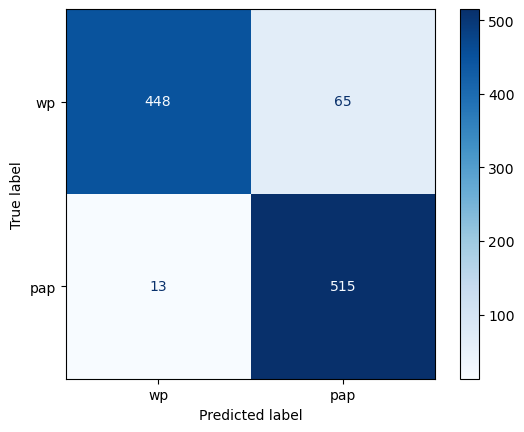

In [5]:
compute_score_specific(model_RF, X_test, y_test)

Average F1 Score: 	0.941


0.9413069579274567

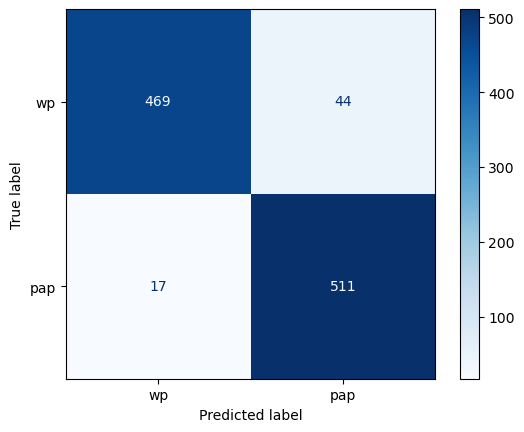

In [6]:
compute_score_specific(model_LR, X_test, y_test)

### Compute test scores (simplified models)

Average F1 Score: 	0.919


0.9191829944547134

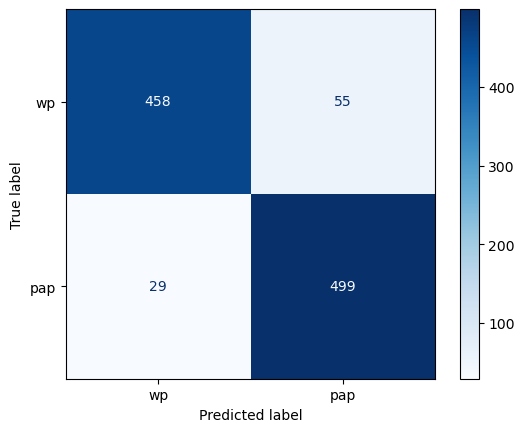

In [7]:
compute_score_specific(model_NB_simplified, X_test, y_test)

Average F1 Score: 	0.914


0.9141602390382878

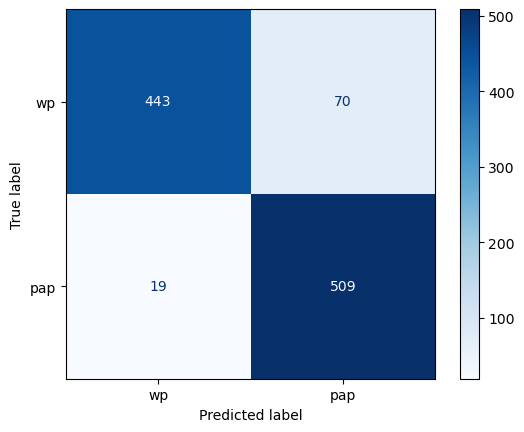

In [8]:
compute_score_specific(model_RF_simplified, X_test, y_test)

Average F1 Score: 	0.921


0.920958183636431

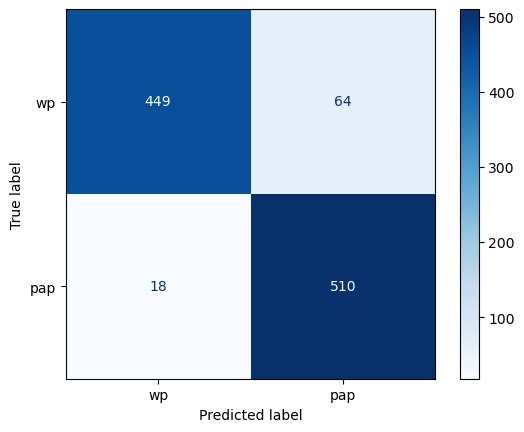

In [9]:
compute_score_specific(model_LR_simplified, X_test, y_test)

### Check wrong predictions

In [10]:
pd.set_option('display.max_colwidth', None)

In [11]:
pap_wrong, wp_wrong = get_wrongs(model_LR, X_test, y_test)

In [12]:
pap_wrong[['cleanedContent', 'hashtags', 'sentiment_score', 'proba']]

,cleanedContent,hashtags,sentiment_score,proba
64,Here's wishing everyone a joyous holiday season! Have a,merrychristmas,0.8398,0.027686
1032,"@HumairaRiaz Yes it is authentic, and yes people can voice their concerns.",NaN,0.6597,0.184147
358,East Coast GRC & Joo Chiat SMC PCF 25th Anniversary Celebration.,NaN,0.0000,0.193918
826,"@Jsnho @Jsnho thanks for caring! Not sure which part of your works is awaiting MSF/NCSS. I would suggest that you get some project started to show track record and proof of concept. And apply for funding either through likes of Our Singapore Fund, National Youth Fund…",NaN,0.8036,0.209392
127,"of outcomes, it's been a privilege. We're still with you, for you, for S'pore!Sincerely,PAP",ge2015,0.4199,0.306007
499,The number of corruption or cheating cases involving public officers has remained low and “fairly stable” over...,NaN,-0.6597,0.312484
321,Joshua Benjamin: I rem 1such visitor remark that he had never ever seen ruling party that had no armies of paid technocrats to support it,NaN,0.4939,0.325267
184,Feb Petir - Looked back at the NCMP debate that happened in Parliament on Jan 29. Read more:,NaN,0.0000,0.327386
652,"@KennethYeo4 @KennethYeo4, indeed we are not immune to racism. From stereotyping people to discrimination, shades of racism exist in any society. However we must not let discrimination be acceptable. As individual, we must check against our own biases.",NaN,0.7906,0.330073
346,"""issues on cleanliness n rats in the vicinity were raised... We will follow up.” - MP Inderjit Singh at Kebun Baru.",NaN,0.0000,0.337548


Observation:

- **Obvious misclassifications**: No. 358 contains 'PCF' and should have been quite closely tied to PAP but was classified wrongly, likely because PCF does not appear often enough in the training set for the model to pick up
- **Not so obvious**: No. 6 may have been misclassified because there are few specific words associated with PAP and the model would need to understand context to classify correctly ('pap' is not an important feature as it occurs in both accounts often)
- **Impossible**: majority are difficult to classify even for humans

In [13]:
wp_wrong[['cleanedContent', 'hashtags', 'sentiment_score', 'proba']]

,cleanedContent,hashtags,sentiment_score,proba
592,"With a backdrop of COVID19 and looming General Elections, it is perhaps timely to re-imagine the Singapore we want to build. What policy directions do we re-examine? What do we keep and build on?Let us know your vision for SG. Take the 5-min survey now:",NaN,0.2869,0.991613
966,Here are 10 ways you can pay it forward to spread some Yuletide cheer this holiday season.,NaN,0.7206,0.953528
586,"Terence: I can assure Mr Ong Ye Kung that we won't oppose for the sake of opposing. However, do you believe there's a need to check the PAP?",NaN,0.3400,0.944019
692,Thank you to all dads out there! Happy 💕💕,fathersday,0.7574,0.943438
631,"Catch the first half of our WP60 documentary as we share with you the journey we've taken with Singapore! | Walking With Singapore: Road to 2011 - | For the best viewing experience, watch in HD.",NaN,0.7712,0.940455
691,Our second episode of The Working Show! Catch the full episode here:,NaN,0.0000,0.931718
530,Join us on Nomination Day!,NaN,0.3595,0.901347
243,We wish all Singaporeans a Happy Racial Harmony Day!,NaN,0.8553,0.895132
968,Wondering about patents developed by Govt research institutions and autonomous unis? | Link:,NaN,0.0000,0.879669
245,"@iamjingxian Hi @iamjingxian! There are lots of ways to contribute as a volunteer. To get a sense of the ways or areas in which you can help, please visit: 😊",NaN,0.6476,0.876846


Observation:

- **Obvious misclassifications**: No. 631 contains 'WP60' and should have been quite closely tied to WP but was classified wrongly, likely because WP60 appears only a few times since it is the 60th anniversary
- **Not so obvious**: No. 896 on David Marshall's passing may have been misclassified because the model may not have understood that 'David Marshall passing' is more associated with WP than PAP
- **Impossible**: majority are difficult to classify even for humans

----

## Business Insights

The Logistic Regression model enables us to examine the contributions of individual features to the prediction. We will focus on the key features that increases the probability of each class (i.e. Twitter account).

In [14]:
# extract coefficients and convert to Dataframe
LR_coef_ = pd.DataFrame(model_LR['model'].coef_[0], 
                        index=model_LR['preproc'].get_feature_names_out(), 
                        columns=['coefficient'])

# process coefficients
LR_coef_ = process_coef(LR_coef_)

In [15]:
# check that the aspects are correctly processed
LR_coef_['aspect'].value_counts()

messaging           1202
content_type           4
engagement_level       3
tone                   1
Name: aspect, dtype: int64

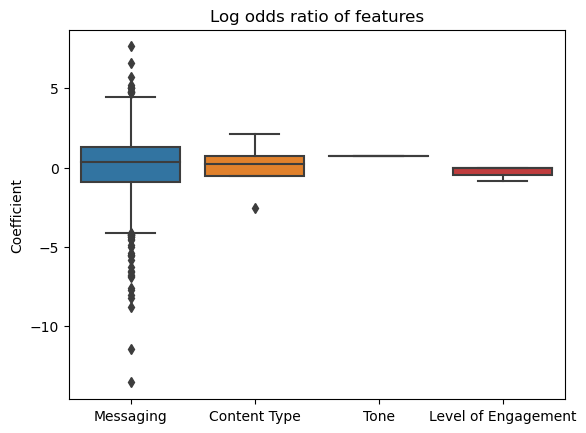

In [19]:
g = sns.boxplot(LR_coef_, x='aspect', y='coefficient')
g.set_xticklabels(['Messaging', 'Content Type', 'Tone', 'Level of Engagement'])

plt.ylabel('Coefficient')
plt.xlabel('')

plt.title('Log odds ratio of features')

plt.show()

In [20]:
LR_coef_.loc[LR_coef_['aspect'] == 'content_type', ['variable', 'coefficient']]

,variable,coefficient
remainder__num_links_TextLink,num_links_TextLink,2.093137
remainder__num_media_Photo,num_media_Photo,0.297545
remainder__num_media_Video,num_media_Video,0.171414
remainder__num_media_Gif,num_media_Gif,-2.554243


Observation:

- **Messaging** features have the greatest impact on the log odds ratio of identifying the account the tweet is from
- **Content type** features are the next most impactful, specifically the presence of a weblink increases the log odds ratio of the account being PAP by 2x while the presence of a GIF increases the ratio of the account being WP by 2.6x
- **Tone** of the tweet has a smaller impact and a positive tone generally increases the odds of the account being PAP. This means that PAP's tweets tend to be more positive
- **Level of Engagement** features generally increases the odds of the tweet being from WP. This means that WP's tweets tend to have greater levels of engagement

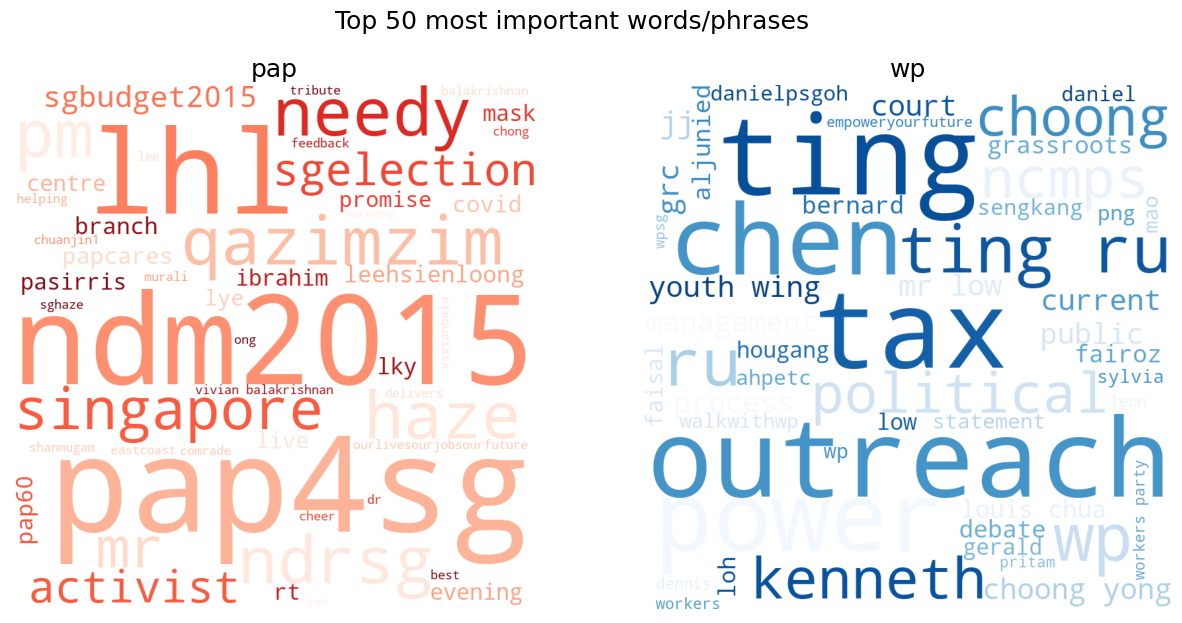

In [25]:
# plotting wordcloud of top 50 words/phrases for each account
messaging_vars = LR_coef_.loc[(LR_coef_['aspect'] == 'messaging'), :]
messaging_vars.set_index('variable', inplace=True)

N = 50

# plot
fig, axes = plt.subplots(ncols=2, figsize=(15,7))

generate_wordcloud(messaging_vars.head(N)['coefficient'], axes[0], 'pap', 'Reds')
generate_wordcloud(messaging_vars.tail(N)['coefficient'], axes[1], 'wp', 'Blues')

plt.suptitle(f'Top {N} most important words/phrases', fontsize=18)
 
plt.show()

Observation:

- Specifically on **Messaging** features, we note that PAP's tweets tend to reference the party (e.g. pap4sg) and PM (e.g. lhl, pm), while WP's tweets similarly reference their MPs (e.g., He Ting Ru, Fairoz, Sylvia) and constituencies (e.g. Sengkang, Hougang, AHPETC)
- PAP's tweets raise key events such as ndm2015, ndrsg. Similarly, WP's tweets focuses on political activities related to them, specifically outreach, grassroots and youth wing
- In terms of policy interests unique to each account, PAP's tweets tend to raise the needy more while WP's tweets focuses on poweer (a.k.a. people's power) and tax

----

## Conclusion and Future Work

- While the classification model is not perfect, it provides a good predictor for identifying which political party's Twitter account a tweet belongs to
- More importantly, the model tells us why, in the terms of the messaging, content type, tone and enagement level
- Examining these details can enable political analysts to better understand the unique interests, philosophies and approach of each party
- Further improvements to the model such as additional new information about the multimedia attachments can further improvement the model performance
- The utility of this project goes beyond that for political analysts. Building on this understanding, political parties can modify the model's outcome variable to suit their objectives, e.g. optimise engagement rates by examining what features in the messaging increases engagement the most

----

## Specific Plots Formatted for Presentation

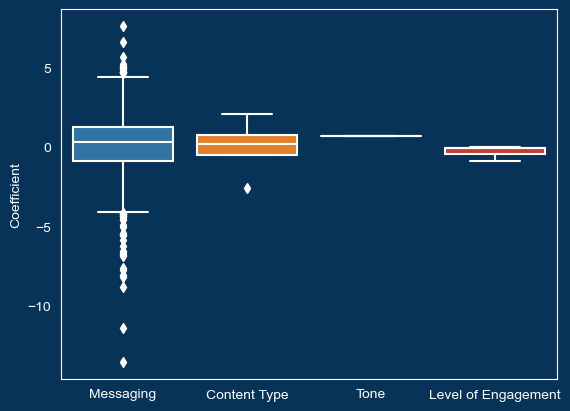

In [26]:
sns.set_style('white')
plt.rcParams['figure.facecolor'] = '#083359'
plt.rcParams['axes.facecolor'] = '#083359'
plt.rcParams['axes.edgecolor'] = 'white'

PROPS = {
    'boxprops':{'edgecolor':'white'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'},
    'flierprops':{'markerfacecolor':'white', 'markeredgecolor':'white'}
}

my_pal = {'messaging':'g', 'content_type':'g', 'tone':'g', 'engagement_level':'g'}
#my_pal = ['g', 'b', 'o', 'r']

g = sns.boxplot(LR_coef_, x='aspect', y='coefficient', **PROPS)
g.set_xticklabels(['Messaging', 'Content Type', 'Tone', 'Level of Engagement'], color='white')

plt.yticks(color='white')
plt.ylabel('Coefficient', color='white')
plt.xlabel('')

plt.show()

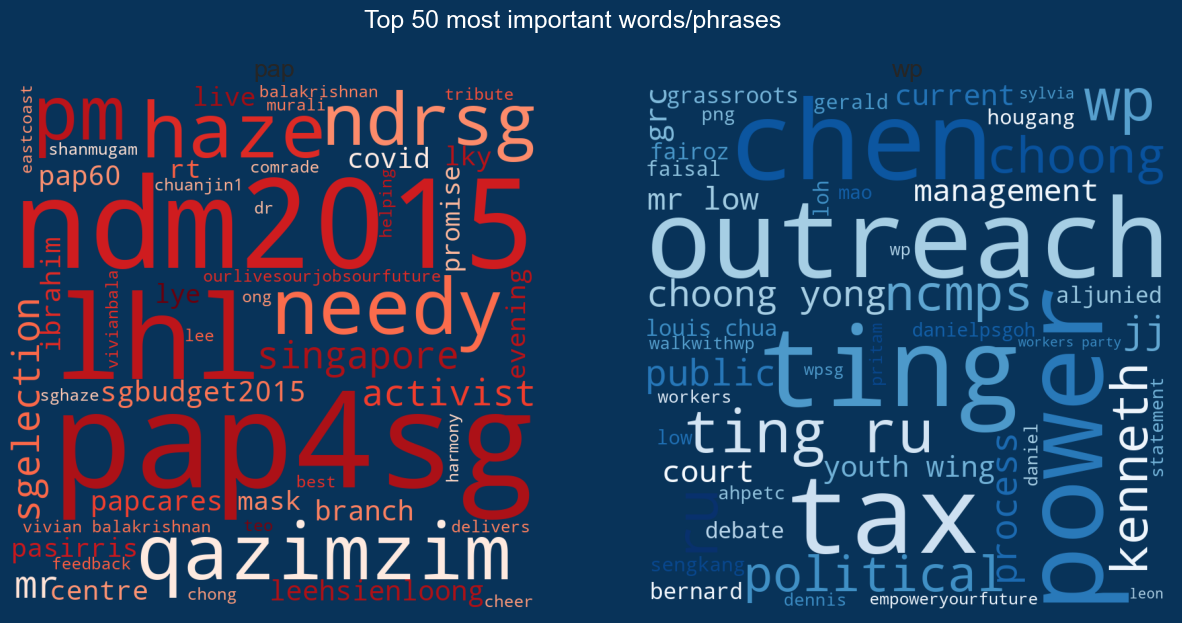

In [27]:
# plotting wordcloud of top 50 words/phrases for each account
messaging_vars = LR_coef_.loc[(LR_coef_['aspect'] == 'messaging'), :]
messaging_vars.set_index('variable', inplace=True)

N = 50

# plot
fig, axes = plt.subplots(ncols=2, figsize=(15,7), facecolor='#083359')

generate_wordcloud(messaging_vars.head(N)['coefficient'], axes[0], 'pap', 'Reds', bgcolor='#083359')
generate_wordcloud(messaging_vars.tail(N)['coefficient'], axes[1], 'wp', 'Blues', bgcolor='#083359')

plt.suptitle(f'Top {N} most important words/phrases', fontsize=18, color='white')
 
plt.show()